# Synthesising Datasets
In this notebook, we combine the **cleaned** datasets that came from other analysis. Geometry needs to be added back into the datasets.

* Inside Airbnb Datasets
* LSOA & Deprivation
* Evictions

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
# This is the Cache Function Jon wrote
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [3]:
# adding the borough data for maps
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/geo/Boroughs.gpkg locally!
Found data/geo/Water.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Done.


In [4]:
lsoa_shp_file = gpd.read_file('LSOA & Dep Data/ESRI/LSOA_2011_London_gen_MHW.shp')

#### Read in 2022 Airbnb Data

In [5]:
#Note, this does not include the geometry because that is not preserved when something is read as a feather. Further, this only includes the fields we are interested in. For the cleaned dataset with all of the fields clean, go to the Airbnb2022_Final.ipynb
listings2022 = pd.read_feather('listings22')

<u>The following Datasets have been Filtered by Terms associated with Gentrification<u>

In [6]:
listings2022_gentrification = pd.read_feather('listings22_gentrification')

In [7]:
listings2022_kensington_chelsea = pd.read_feather('listings22_kensington_chelsea')

In [8]:
listings2022_camden = pd.read_feather('listings22_camden')

In [9]:
listings2022_hackney = pd.read_feather('listings22_hackney')

#### Read in 2019 Airbnb Data

#### Read in Eviction Data

In [10]:
evict2019 = pd.read_csv('2019_evictions_geom')

In [11]:
evict2022 = pd.read_csv('2022_evictions_geom')

#### Read in LSOA & IMD Data
This data is for each borough that we are targetting but broken down into LSOAs so we can get a more micro level view of deprivation there.

In [12]:
hackney_dep = pd.read_csv('LSOA & Dep Data/hackLSOA_dep')

In [13]:
camden_dep = pd.read_csv('LSOA & Dep Data/CamdenLSOA_dep')

In [14]:
kc_dep = pd.read_csv('LSOA & Dep Data/kcLSOA_dep')

In [15]:
London_dep = pd.read_csv('LSOA & Dep Data/London_dep')

In [16]:
London_dep.columns.tolist()

['Unnamed: 0',
 'LSOA11CD',
 'LSOA11NM',
 'geometry',
 'LSOA code (2011)',
 'Local Authority District code (2019)',
 'LAD',
 'Barriers to Housing and Services Score',
 'Barriers to Housing and Services Rank (where 1 is most deprived)',
 'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)',
 'transformed_mms']

In [17]:
London_borough_dep = London_dep.groupby('LAD')['Barriers to Housing and Services Score'].agg('mean')

In [18]:
London_borough_dep.info(verbose=True)

<class 'pandas.core.series.Series'>
Index: 33 entries, Barking and Dagenham to Westminster
Series name: Barriers to Housing and Services Score
Non-Null Count  Dtype  
--------------  -----  
33 non-null     float64
dtypes: float64(1)
memory usage: 528.0+ bytes


### Merging 2022 Airbnb Data: All London

In [66]:
airbnb_merged1 = pd.merge(listings2022, evict2022, how="inner", left_on='neighbourhood_cleansed', 
                          right_on='Area', suffixes=('neighbourhood_cleansed', 'Area'))

In [72]:
airbnb_merged2 = pd.merge(airbnb_merged1, London_borough_dep, how="inner", left_on='neighbourhood_cleansed', 
                          right_on='LAD', suffixes=('neighbourhood_cleansed', 'Area'))

In [73]:
airbnb_merged2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69054 entries, 0 to 69053
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   id                                      69054 non-null  int64   
 1   name                                    69034 non-null  object  
 2   description                             67827 non-null  object  
 3   host_id                                 69054 non-null  int64   
 4   host_location                           56983 non-null  category
 5   host_listings_count                     69054 non-null  UInt16  
 6   host_total_listings_count               69054 non-null  UInt16  
 7   neighbourhood_cleansed                  69054 non-null  object  
 8   latitude                                69054 non-null  float64 
 9   longitude                               69054 non-null  float64 
 10  property_type                           69054 

In [74]:
airbnb_merged2.sample(5)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,...,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,area,density,Standardised Evictions,Barriers to Housing and Services Score
26748,26719908,Lovely Room & Private Bathroom in Heart of London,A spacious double bedroom in a quiet and char...,67136977,"London, United Kingdom",2,2,Barnet,51.60,-0.17,...,Barnet,E09000003,"8,674.84",0.00,F,"MULTIPOLYGON (((524579.9 198355.2, 524594.3 19...","86,748,313.71",0.02,-0.67,30.95
7959,666795095814155904,Earls Court amazing apartment,Amazing two bedroom apartment in the heart of ...,376737833,"England, United Kingdom",11,17,Kensington and Chelsea,51.49,-0.19,...,Kensington and Chelsea,E09000020,"1,238.38",25.99,T,"MULTIPOLYGON (((526219.7 176948, 526208.8 1769...","12,123,847.99",0.25,-0.33,36.07
62479,707223623246346880,Cheerful 5 bedroom townhouse with hot tub,Have fun with the whole family at this stylish...,2305090,"Leeds, United Kingdom",2,2,Lewisham,51.43,-0.04,...,Lewisham,E09000023,"3,531.71",16.80,T,"MULTIPOLYGON (((536691 178958.6, 536691.9 1789...","35,149,084.92",0.06,-0.67,34.73
29103,25364250,Luxury 2 Bed Flat - Chelsea Harbour,Modern luxury two double bedroom apartment by ...,89082681,"London, United Kingdom",1,2,Hammersmith and Fulham,51.47,-0.18,...,Hammersmith and Fulham,E09000013,"1,715.41",75.65,T,"MULTIPOLYGON (((521975.8 178100, 521973 178109...","16,397,617.54",NaN,NaN,28.11
22832,20458359,Room in Tooting,It is a bright and spacious double bedroom wit...,143054174,"London, United Kingdom",2,6,Wandsworth,51.43,-0.17,...,Wandsworth,E09000032,"3,522.02",95.60,T,"MULTIPOLYGON (((523489.6 176224.8, 523500.6 17...","34,264,163.18",0.09,-0.33,26.74


In [60]:
airbnb_merged2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69054 entries, 0 to 69053
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   id                                      69054 non-null  int64   
 1   name                                    69034 non-null  object  
 2   description                             67827 non-null  object  
 3   host_id                                 69054 non-null  int64   
 4   host_location                           56983 non-null  category
 5   host_listings_count                     69054 non-null  UInt16  
 6   host_total_listings_count               69054 non-null  UInt16  
 7   neighbourhood_cleansed                  69054 non-null  object  
 8   latitude                                69054 non-null  float64 
 9   longitude                               69054 non-null  float64 
 10  property_type                           69054 

In [81]:
airbnb_merged2.crs = {'init': 'epsg:4326'}
airbnb_merged2 = airbnb_merged2.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [85]:
airbnb_merged2.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

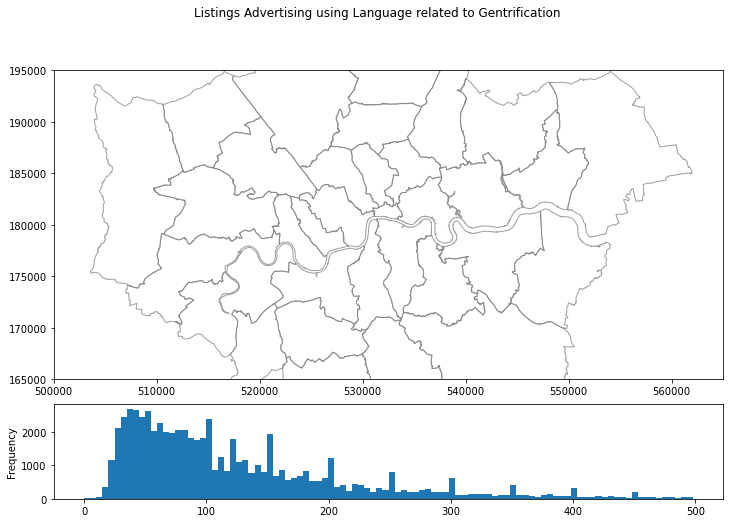

In [84]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
airbnb_merged2.plot(markersize=2, column='price', cmap='magma', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
airbnb_merged2[airbnb_merged2.price<airbnb_merged2.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("Listings Advertising using Language related to Gentrification")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

### Merging 2022 Airbnb Data & LSOA: Kensington and Chelsea

In [19]:
# listings2022_kensington_chelsea = gpd.GeoDataFrame(listings2022_kensington_chelsea,geometry=gpd.points_from_xy(listings2022_kensington_chelsea .longitude, listings2022_kensington_chelsea .latitude, crs='epsg:4326'))

In [20]:
# listings2022_kensington_chelsea = gpd.GeoDataFrame(listings2022_kensington_chelsea, geometry='geometry')
# listings2022_kensington_chelsea.crs = {'init': 'epsg:4326'}
# listings2022_kensington_chelsea.to_crs('epsg:27700')

In [21]:
# imd2019_house_geom = shp_file.merge(imd2019_housing, how="left", left_on='LSOA11CD', right_on='LSOA code (2011)')

In [23]:
kc_dep = lsoa_shp_file.merge(kc_dep, how="left", left_on='LSOA11CD', right_on='LSOA code (2011)')

In [24]:
kc_dep.head(5)

,LSOA11CD_x,LSOA11NM_x,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,LSOA11CD_y,LSOA11NM_y,geometry_y,LSOA code (2011),Local Authority District code (2019),LAD,Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),transformed_mms
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
kc_dep = gpd.GeoDataFrame(kc_dep, geometry='geometry')

ValueError: Unknown column geometry

In [109]:
kc_dep.crs = {'init': 'epsg:4326'}
kc_dep.to_crs('epsg:27700')

ValueError: Unknown column geometry

In [102]:
kc_dep = gpd.GeoDataFrame(kc_dep, geometry='geometry')
kc_dep.crs = {'init': 'epsg:4326'}


TypeError: Input must be valid geometry objects: POLYGON ((525802.22499993 179074.02600009655, 525809.31300002 179038.31200008892, 525836.9239999217 179044.68700001875, 525816.245999932 178949.72599998413, 525752.1880000643 178863.78099993948, 525724.5019999518 178863.7969999716, 525674.654999911 178863.82500007612, 525668.875999967 178863.82800004585, 525619.5459999351 178862.30499993014, 525529.9739999088 178858.36599999998, 525524.998999981 178929.00000009182, 525517.0809999437 178927.57499995496, 525506.7209999673 178978.60600004843, 525483.50000009 178975.75000002878, 525475.4260000784 179006.48899991513, 525552.9990000218 179014.99999996863, 525554.4880000936 178983.662999923, 525583.9989999842 178988.00000009505, 525574.4879999569 179077.21400005644, 525580.0240000302 179078.35999991186, 525567.0000000322 179178.9999999317, 525608.4029999241 179201.85799998802, 525661.5370000872 179240.16599994941, 525777.7499999322 179245.359, 525787.6750000401 179125.75900007412, 525802.22499993 179074.02600009655))

In [100]:
kc_merged = gpd.sjoin(listings2022_kensington_chelsea, kc_dep, how='inner', predicate='within', 
                      left_on='geometry', right_on='geometry')

TypeError: sjoin() got an unexpected keyword argument 'left_on'

In [101]:
kc_merged = gpd.sjoin(listings2022_kensington_chelsea, kc_dep)

ValueError: 'right_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

In [88]:
kc_dep.head(5)

,Unnamed: 0,LSOA11CD,LSOA11NM,geometry,LSOA code (2011),Local Authority District code (2019),LAD,Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),transformed_mms
0,2747,E01002812,Kensington and Chelsea 013A,"POLYGON ((525802.22499993 179074.02600009655, ...",E01002812,E09000020,Kensington and Chelsea,40.75,1981,1,0.53
1,2748,E01002813,Kensington and Chelsea 011A,"POLYGON ((525387.795999887 179246.17700007392,...",E01002813,E09000020,Kensington and Chelsea,27.38,8934,3,0.32
2,2749,E01002814,Kensington and Chelsea 015A,POLYGON ((524895.6830000001 178963.19300005032...,E01002814,E09000020,Kensington and Chelsea,45.49,971,1,0.61
3,2750,E01002815,Kensington and Chelsea 011B,POLYGON ((525506.7210000233 178978.60600006193...,E01002815,E09000020,Kensington and Chelsea,43.44,1341,1,0.57
4,2751,E01002816,Kensington and Chelsea 011C,POLYGON ((525549.6320000419 179387.75600001463...,E01002816,E09000020,Kensington and Chelsea,36.54,3401,2,0.47


### Merging 2022 Airbnb Data: Camden

### Merging 2022 Airbnb Data: Hackney